## ThinkDSP

This notebook contains code examples from Chapter 3: Non-periodic signals

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

### Chirp

Make a linear chirp from A3 to A5.

In [3]:
from thinkdsp import Chirp

signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

Here's what the waveform looks like near the beginning.

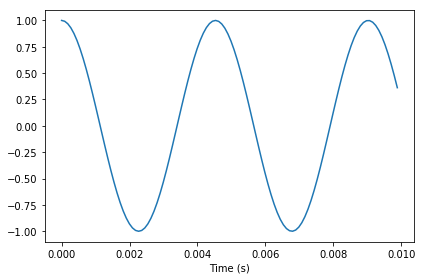

In [4]:
wave1.segment(start=0, duration=0.01).plot()
decorate(xlabel='Time (s)')

And near the end.

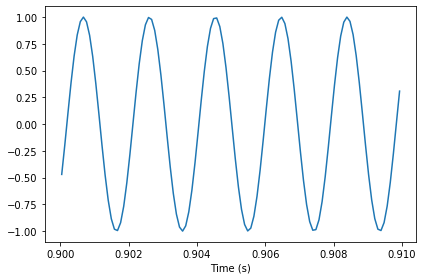

In [5]:
wave1.segment(start=0.9, duration=0.01).plot()
decorate(xlabel='Time (s)')

Here's an exponential chirp with the same frequency range and duration.

----

人们对音高的感知差异通过“音程”区分，两个音的音程取决于两个音的比例，所以人们对音高的感知符合频率的对数关系：  
如果频率线性增加，我们感知到的频率增加是对数的  
所以如果要感知到线性增加的音高，则频率要按照指数增加，即音高间的对数值值间隔相同


In [5]:
from thinkdsp import ExpoChirp

signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

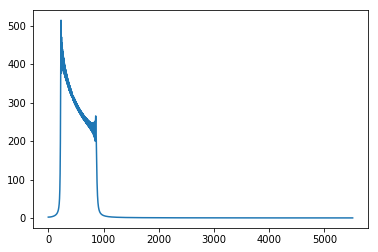

In [8]:
wave2.make_spectrum().plot()

## Leakage

Spectral leakage is when some of the energy at one frequency appears at another frequency (usually nearby).

Let's look at the effect of leakage on a sine signal (which only contains one frequency component).

----

- 频谱泄露产生于`被处理的波形/波形片段反映的是一个周期信号的整数倍周期内的变化`的假设与事实不符。
- 最常见的一个矛盾便是片段的开始和结尾无法连续。
- 该问题可以通过平滑片段的开始与结束（即`加窗`）来缓解（但这样会带来信号的衰弱）


In [9]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)

If the duration is an integer multiple of the period, the beginning and end of the segment line up, and we get minimal leakage.

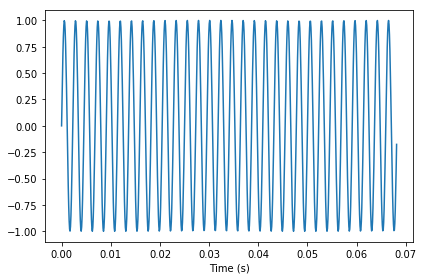

In [10]:
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

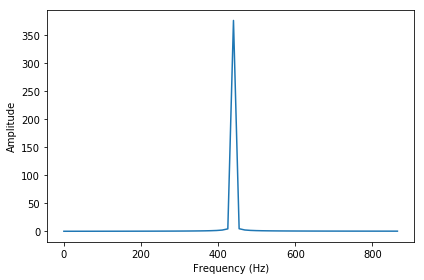

In [11]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

If the duration is not a multiple of a period, the leakage is pretty bad.

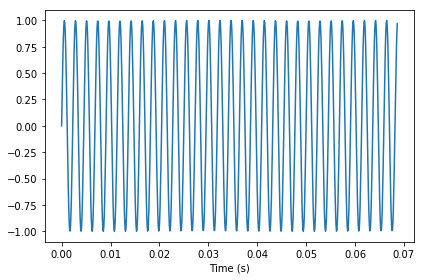

In [12]:
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

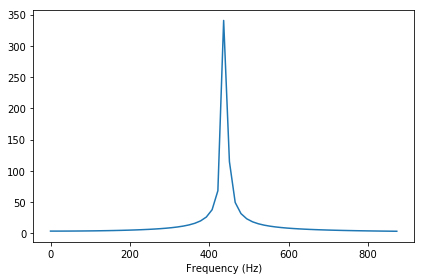

In [13]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

Windowing helps (but notice that it reduces the total energy).

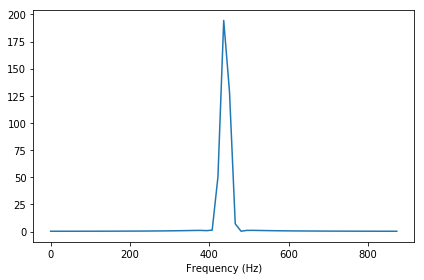

In [14]:
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

## Spectrogram

If you blindly compute the DFT of a non-periodic segment, you get "motion blur".

----

- 频谱图的时间分辨率和频率分辨率有**Gabor限制**
  - 假定$n$是片段长度（奈奎斯特率），频谱包含$\frac{n}{2}$个元素。如果波形图的帧率是$r$（奈奎斯特率），则频谱中最高频率为$\frac{r}{2}$，则：
  - 时间分辨率为$\frac{n}{r}$
  - 频率分辨率为$\frac{r}{n}$（$\frac{\frac{r}{2}}{\frac{n}{2}}$）（理解成Wave范围是r/2的频谱用n/2个单位表示，每个格子代表频率r/n）
- 理想情况下，希望时间分辨率与频率分辨率皆较大
  - 时间分辨率越大，频谱图中片段越窄，越容易看出频率的变化趋势
  - 频率分辨率越大，频谱图中每个片段的频带粒度越小，越容易观察出频率的微小变化
  - 如，片段时长加倍，则频率分辨率加倍，而时间分辨率减半

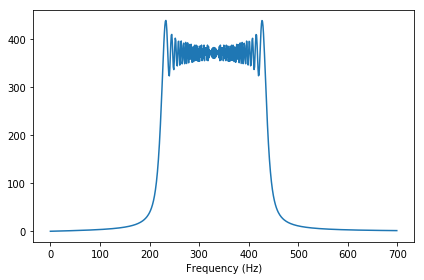

In [18]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()
spectrum.plot(high=700)
decorate(xlabel='Frequency (Hz)')

A spectrogram is a visualization of a short-time DFT that lets you see how the spectrum varies over time.

----

- `make_spectrogram()`实现思路：按照长度为`seg_length`、步长为`seg_length/2`截取Wave的帧形成片段（注意Wave是由Singal按照`framerate`采样求值得到的），对片段加窗缓解频谱泄露，对加窗后的片段调用`make_spectrum()`并将频谱按颜色深浅打竖排列在片段所在时间区间的中点位置。
- **为什么步长要用seg_length的一半？？？**

In [34]:
def plot_spectrogram(wave, seg_length):
    """
    """
    spectrogram = wave.make_spectrogram(seg_length)
    print('Time resolution (s)', spectrogram.time_res)
    print('Frequency resolution (Hz)', spectrogram.freq_res)
    spectrogram.plot(high=700)
    decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Time resolution (s) 0.046439909297052155
Frequency resolution (Hz) 21.533203125


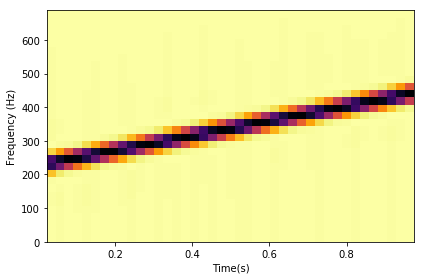

In [30]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
plot_spectrogram(wave, 512)

If you increase the segment length, you get better frequency resolution, worse time resolution.

Time resolution (s) 0.09287981859410431
Frequency resolution (Hz) 10.7666015625


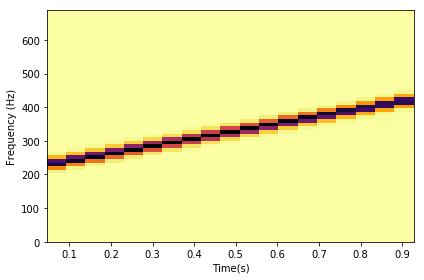

In [31]:
plot_spectrogram(wave, 1024)

If you decrease the segment length, you get better time resolution, worse frequency resolution.

Time resolution (s) 0.023219954648526078
Frequency resolution (Hz) 43.06640625


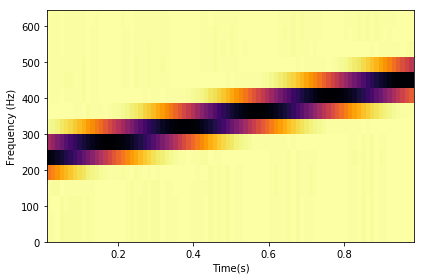

In [32]:
plot_spectrogram(wave, 256)

In [33]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=128, max=4096, value=100, step=128)
interact(plot_spectrogram, wave=fixed(wave), seg_length=slider);

interactive(children=(IntSlider(value=128, description='seg_length', max=4096, min=128, step=128), Output()), …

## Spectrum of a chirp

The following interaction lets you customize the Eye of Sauron as you vary the start and end frequency of the chirp.

In [24]:
def eye_of_sauron(start, end):
    """Plots the spectrum of a chirp.
    
    start: initial frequency
    end: final frequency
    """
    signal =  Chirp(start=start, end=end)
    wave = signal.make_wave(duration=0.5)
    spectrum = wave.make_spectrum()
    
    spectrum.plot(high=1200)
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [25]:
slider1 = widgets.FloatSlider(min=100, max=1000, value=100, step=50)
slider2 = widgets.FloatSlider(min=100, max=1000, value=200, step=50)
interact(eye_of_sauron, start=slider1, end=slider2);

interactive(children=(FloatSlider(value=100.0, description='start', max=1000.0, min=100.0, step=50.0), FloatSl…